Epoch 1/5 - Loss: 1.0859
Epoch 2/5 - Loss: 0.6225
Epoch 3/5 - Loss: 0.3756
Epoch 4/5 - Loss: 0.1386
Epoch 5/5 - Loss: 0.0425


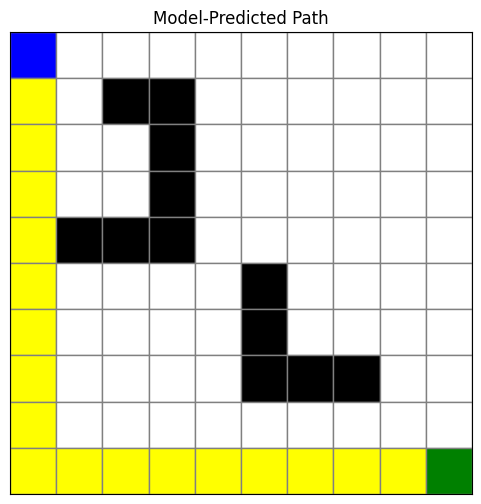

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/content/training_data_expanded_columns.csv")
X_data = df[[f"cell_{i}" for i in range(100)]].values
y_data = df["Label_Direction_Index"].values

# Convert to tensors
X_tensor = torch.tensor(X_data, dtype=torch.float32)
y_tensor = torch.tensor(y_data, dtype=torch.long)

# Create dataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define model
class MLPAgent(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )
    def forward(self, x):
        return self.net(x)

# Initialize model, optimizer, loss
model = MLPAgent()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Training loop
EPOCHS = 5
for epoch in range(EPOCHS):
    total_loss = 0
    for xb, yb in loader:
        preds = model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss / len(loader):.4f}")

# Predict path step-by-step using the trained model
def model_predict_path(model, grid, start, goal, max_steps=100):
    path = [start]
    current = start
    for _ in range(max_steps):
        state = np.copy(grid)
        state[current] = 2
        state[goal] = 3
        input_tensor = torch.tensor(state.flatten(), dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            logits = model(input_tensor)
            move_idx = torch.argmax(logits).item()
        dr, dc = [(-1, 0), (1, 0), (0, -1), (0, 1)][move_idx]
        next_pos = (current[0] + dr, current[1] + dc)
        if (0 <= next_pos[0] < 10 and 0 <= next_pos[1] < 10 and
            grid[next_pos] != 1 and next_pos not in path):
            path.append(next_pos)
            current = next_pos
            if current == goal:
                break
        else:
            break
    return path

# Visualize the path on the grid
def visualize_path_prediction(grid, path, title="Model-Predicted Path"):
    fig, ax = plt.subplots(figsize=(6, 6))
    for r in range(10):
        for c in range(10):
            coord = (c, 9 - r)
            if (r, c) == path[0]:
                color = 'blue'
            elif (r, c) == path[-1]:
                color = 'green'
            elif (r, c) in path:
                color = 'yellow'
            elif grid[r][c] == 1:
                color = 'black'
            else:
                color = 'white'
            rect = plt.Rectangle(coord, 1, 1, facecolor=color, edgecolor='gray')
            ax.add_patch(rect)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    ax.set_aspect('equal')
    plt.show()

# Run prediction on first training sample
test_grid = X_tensor[0].view(10, 10).int().numpy()
start = tuple(map(int, np.argwhere(test_grid == 2)[0]))
goal = tuple(map(int, np.argwhere(test_grid == 3)[0]))

predicted_path = model_predict_path(model, test_grid, start, goal)
visualize_path_prediction(test_grid, predicted_path, title="Model-Predicted Path")

